In [1]:
import os
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization, ReLU, Concatenate
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)


IMG_SIZE = 128
OUTPUT_CHANNELS = 3
BATCH_SIZE = 1

In [2]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255)
    return image


def load_Tensor(U, E):
    E_dataset = tf.data.Dataset.list_files(E, shuffle=False)
    E_dataset = E_dataset.map(load, num_parallel_calls=tf.data.AUTOTUNE)
    U_dataset = tf.data.Dataset.list_files(U, shuffle=False)
    U_dataset = U_dataset.map(load, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = tf.data.Dataset.zip((U_dataset, E_dataset))
    dataset = dataset.shuffle(dataset.cardinality())
    dataset = dataset.batch(BATCH_SIZE)
    return dataset


def get_Users(folder):
    _dirs = [f for f in glob.glob(folder+'*') if os.path.isdir(f) and f.split('_')[-2] == 'E']
    unique_users = list(set([n.split('\\')[-1].split('_')[0] for n in _dirs]))
    train_users, test_users = train_test_split(unique_users, test_size=0.05)
    train_users, validation_users = train_test_split(train_users, test_size=0.3)
    return train_users, test_users, validation_users


def get_Dataset(folder, users):
    E_dirs = [f for f in glob.glob(folder+'*') if os.path.isdir(f) and f.split('_')[-2] == 'E']
    U_dirs = [f for f in glob.glob(folder+'*') if os.path.isdir(f) and f.split('_')[-2] == 'U']

    E_ = [f+'/*' for f in E_dirs if f.split('\\')[-1].split('_')[0] in users]
    U_ = [f+'/*' for f in U_dirs if f.split('\\')[-1].split('_')[0] in users]

    _data = load_Tensor(U_, E_)
    return _data


def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = Sequential()
    result.add(Conv2D(filters, size, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(ReLU())
    result.add(MaxPooling2D())
    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.5))

    result.add(ReLU())
    return result


def Generator():
    inputs = Input(shape=[IMG_SIZE, IMG_SIZE, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        #downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        #upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer, activation='sigmoid')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)
    return Model(inputs=inputs, outputs=x)


def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None, xlim=None):
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

In [4]:
dataset_path = 'Squared_Heads/'
train, test, valid = get_Users(dataset_path)
print(len(train), len(test), len(valid))

105 8 46


In [5]:
train_dataset = get_Dataset(dataset_path, train)
valid_dataset = get_Dataset(dataset_path, valid)
test_dataset = get_Dataset(dataset_path, test)

In [6]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

61926 27508 4769


In [5]:
model = Generator()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 64)   3072        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 32, 128)  131584      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 16, 16, 256)  525312      ['sequential_1[0][0]']       

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy')

model.fit(train_dataset, epochs=1, validation_data=[valid_dataset])

62526/62526 [==============================] - 3061s 45ms/step - loss: 0.4718 - val_loss: 0.5347


['071', '064', '021', '138', '044', '034', '098', '142']
1/1 [==============================] - 0s 20ms/step


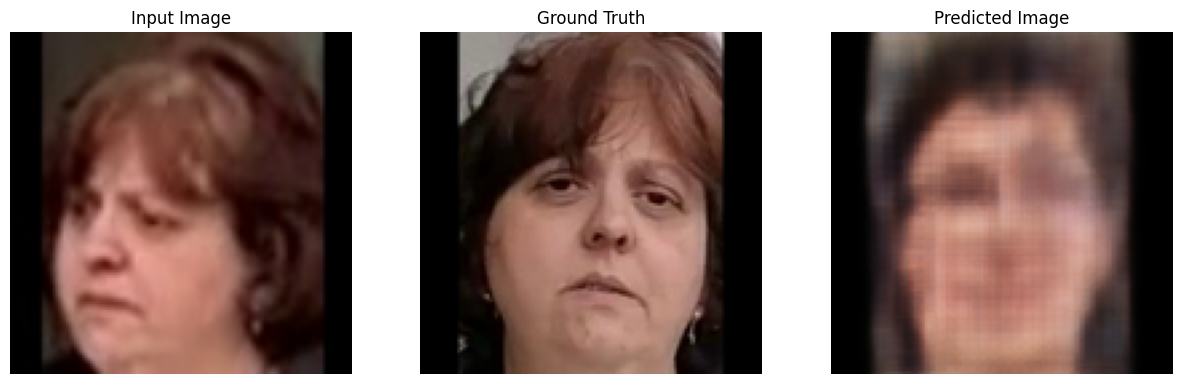

1/1 [==============================] - 0s 20ms/step


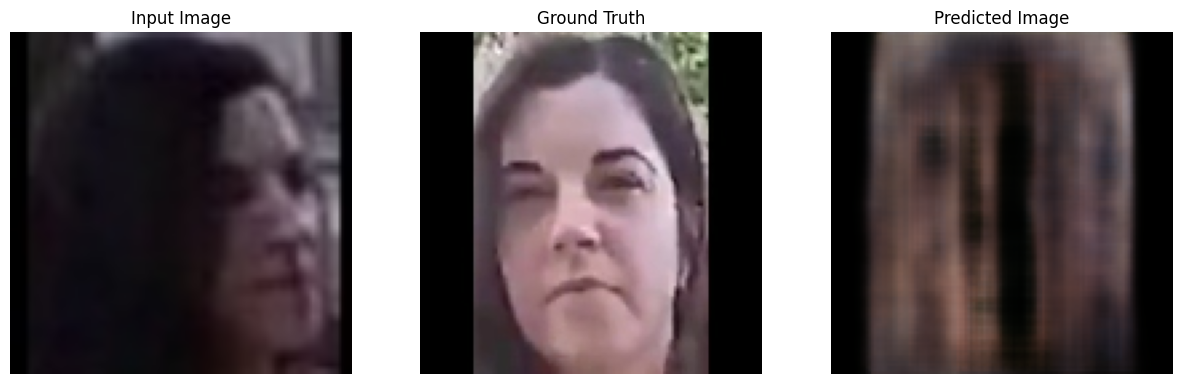

1/1 [==============================] - 0s 20ms/step


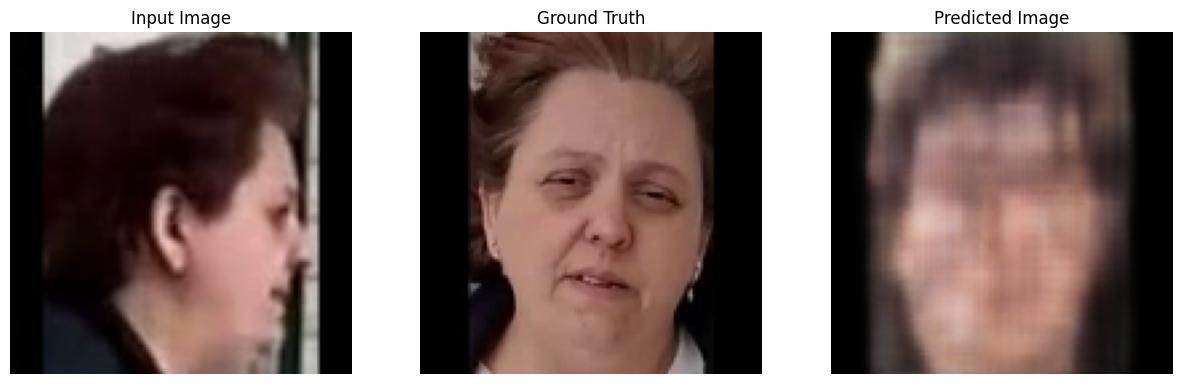

1/1 [==============================] - 0s 20ms/step


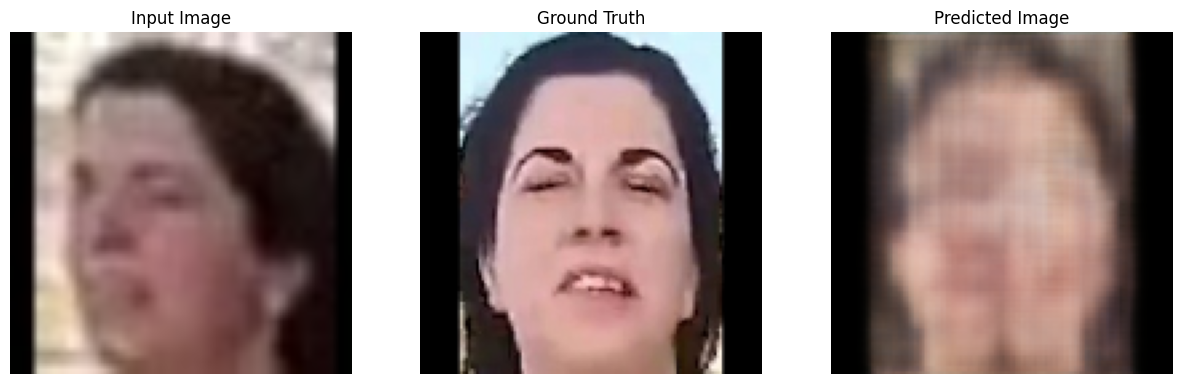

1/1 [==============================] - 0s 20ms/step


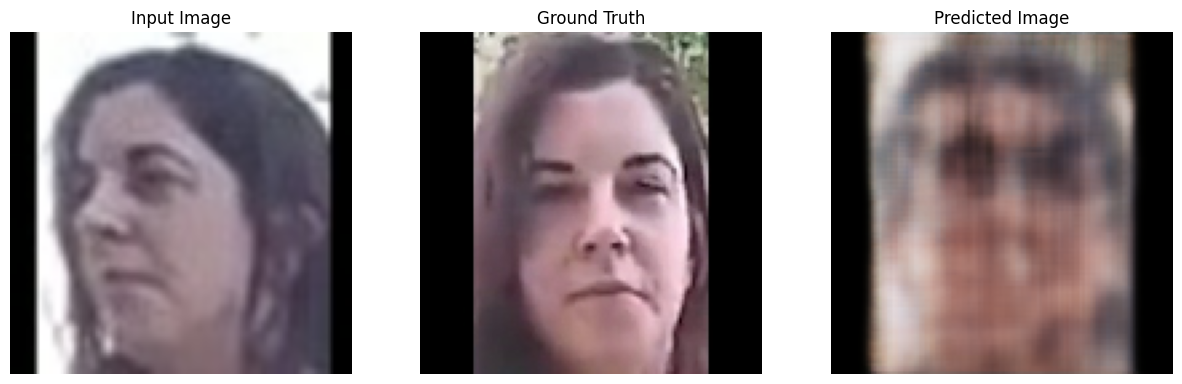

1/1 [==============================] - 0s 20ms/step


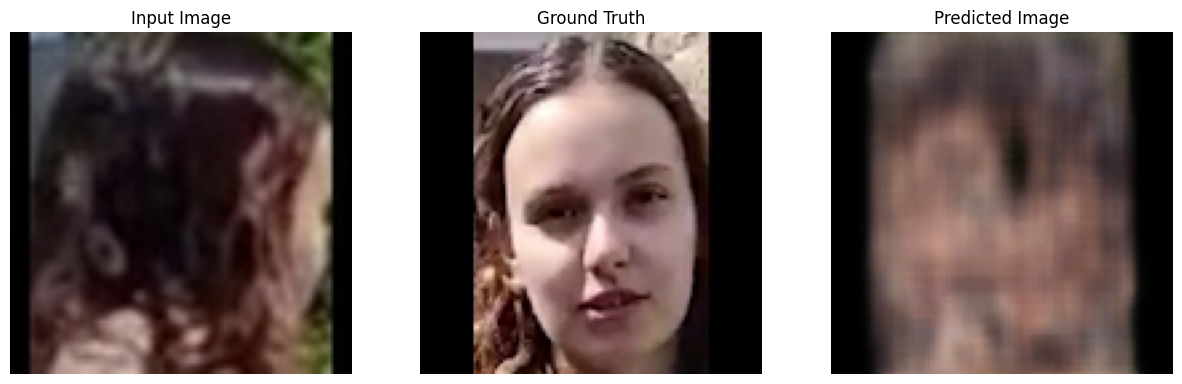

1/1 [==============================] - 0s 19ms/step


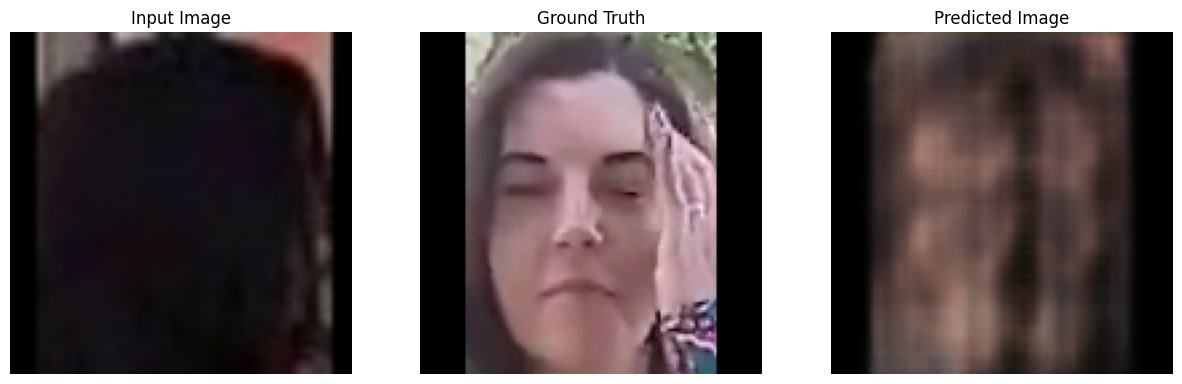

1/1 [==============================] - 0s 40ms/step


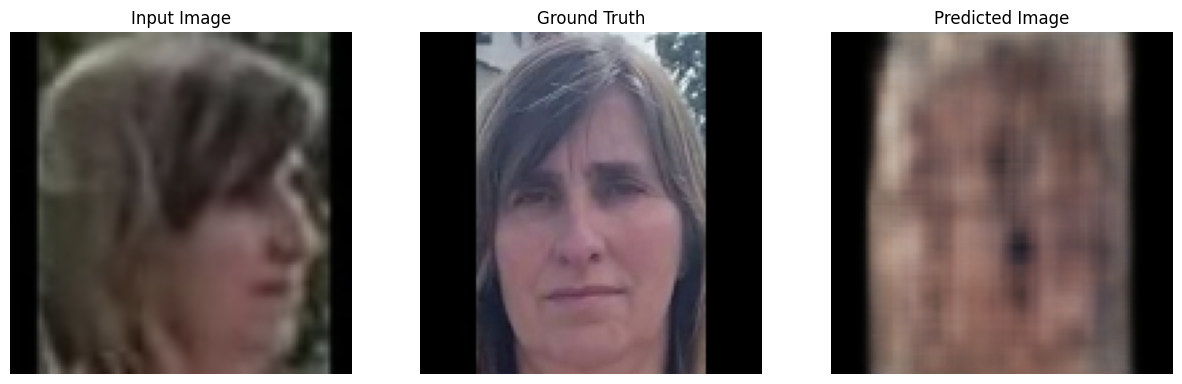

1/1 [==============================] - 0s 19ms/step


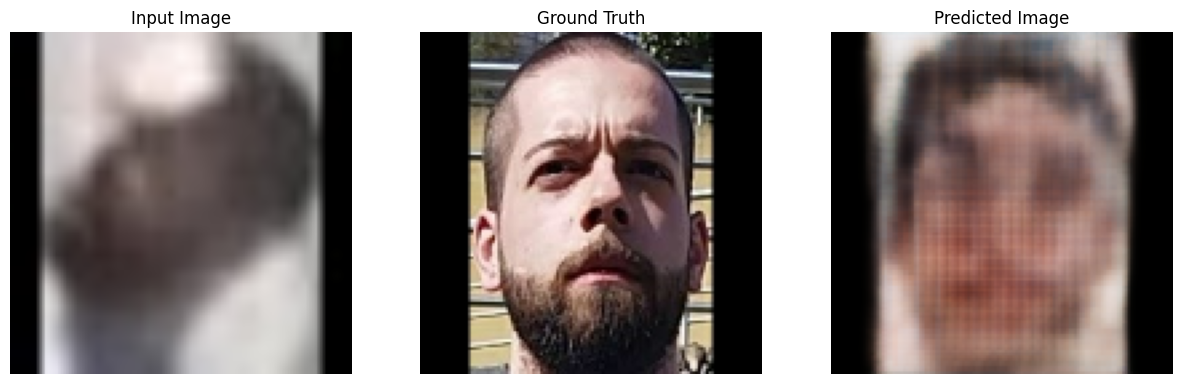

1/1 [==============================] - 0s 20ms/step


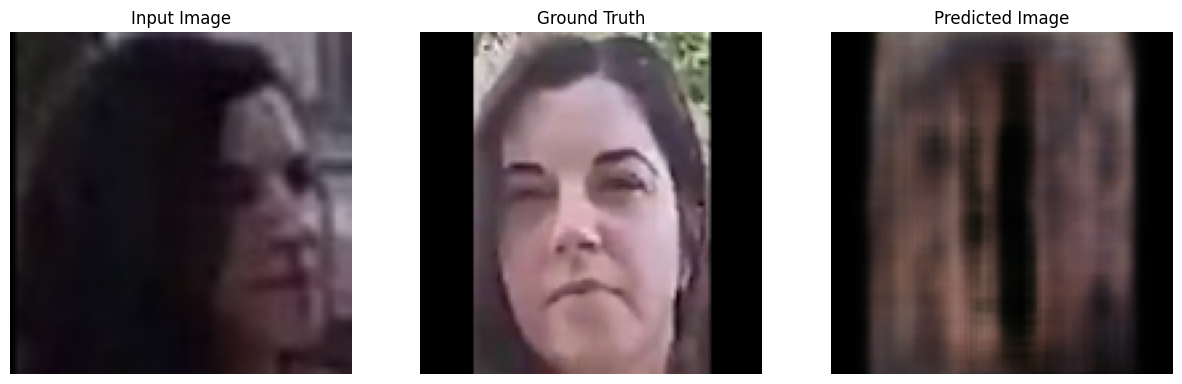

In [12]:
print(test)
for inp, tar in test_dataset.take(10):
    prediction = model.predict(inp)
    plt.figure(figsize=(15, 15))

    display_list = [inp[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()